In [1]:
import json
import numpy as np
import matplotlib.pyplot as plt

figsize = (10,6)
pktPayloadSize = 1460 # Bytes

In [2]:
def removekey(d, key):
    r = dict(d)
    del r[key]
    return r

In [3]:
workloadName = '_W5'
networkLoad = 0.8
simName = workloadName + '_load-' + str(int(networkLoad*100)) + 'p'
numSim = 8

In [4]:
msgStartEntryDict = {}
msgCompletionTimesDict = {}

for i in range(numSim):
    with open("MsgTraces"+simName+"_"+str(i)+".tr",'r') as f:
        for line in f:
            msgLog = line.split()

            time = float(msgLog[1])*1e-9        # in seconds
            msgSize = int(msgLog[2])#//1462*1462 # in bytes
            sender = msgLog[3]                  # ip:port
            receiver = msgLog[4]                # ip:port
            txMsgId = int(msgLog[5])

            key = (sender, receiver, txMsgId, i)

            if (msgLog[0]=='+'):
                if (key in msgStartEntryDict):
                    msgStartEntryDict[key].append(time)
                else:
                    msgStartEntryDict[key] = [time]

            elif (msgLog[0] =='-'):
                if (key in msgStartEntryDict):
                    startTime = msgStartEntryDict[key].pop()
                    if (len(msgStartEntryDict[key]) <= 0):
                        msgStartEntryDict = removekey(msgStartEntryDict, key)

                    if (msgSize in msgCompletionTimesDict):
                        msgCompletionTimesDict[msgSize].append(time-startTime)
                    else:
                        msgCompletionTimesDict[msgSize] = [time-startTime]
                else:
                    print('ERROR: Start entry of message (' \
                          + sender + ' > ' + receiver + ', ' + str(txMsgId) \
                          + ') not found!')

In [5]:
i = 0
for msgKey, msgStartTimes in msgStartEntryDict.items():
    print(msgKey, ' : ', msgStartTimes)
    i += len(msgStartTimes)
print ('Number of uncompleted messages: ' + str(i))

('10.0.40.1:1040', '10.0.70.1:1070', 27, 4)  :  [3.070594695]
('10.0.70.1:1070', '10.0.79.1:1079', 35, 1)  :  [3.0990365090000003]
('10.0.92.1:1092', '10.0.15.1:1015', 8, 4)  :  [3.0277021200000003]
('10.0.62.1:1062', '10.0.54.1:1054', 39, 3)  :  [3.090875612]
('10.0.79.1:1079', '10.0.40.1:1040', 17, 1)  :  [3.040177282]
('10.0.46.1:1046', '10.0.105.1:1105', 11, 7)  :  [3.028051842]
('10.0.14.1:1014', '10.0.117.1:1117', 56, 4)  :  [3.143155059]
('10.0.32.1:1032', '10.0.76.1:1076', 116, 1)  :  [3.274709327]
('10.0.95.1:1095', '10.0.31.1:1031', 89, 7)  :  [3.2744405120000004]
('10.0.42.1:1042', '10.0.98.1:1098', 99, 6)  :  [3.2875871040000004]
('10.0.56.1:1056', '10.0.57.1:1057', 38, 6)  :  [3.0825775990000004]
('10.0.30.1:1030', '10.0.3.1:1003', 102, 6)  :  [3.2862185750000004]
('10.0.97.1:1097', '10.0.87.1:1087', 81, 1)  :  [3.1970304580000004]
('10.0.120.1:1120', '10.0.141.1:1141', 90, 0)  :  [3.2337231550000003]
('10.0.60.1:1060', '10.0.52.1:1052', 5, 0)  :  [3.019795649]
('10.0.30.1

('10.0.23.1:1023', '10.0.135.1:1135', 72, 6)  :  [3.1905917460000004]
('10.0.64.1:1064', '10.0.78.1:1078', 106, 0)  :  [3.305633186]
('10.0.116.1:1116', '10.0.80.1:1080', 79, 6)  :  [3.237829479]
('10.0.127.1:1127', '10.0.31.1:1031', 13, 7)  :  [3.032660782]
('10.0.66.1:1066', '10.0.113.1:1113', 10, 1)  :  [3.021763855]
('10.0.26.1:1026', '10.0.132.1:1132', 97, 3)  :  [3.278762674]
('10.0.40.1:1040', '10.0.76.1:1076', 100, 7)  :  [3.2558539150000003]
('10.0.35.1:1035', '10.0.138.1:1138', 58, 7)  :  [3.1581698200000003]
('10.0.58.1:1058', '10.0.46.1:1046', 89, 3)  :  [3.199724969]
('10.0.62.1:1062', '10.0.69.1:1069', 57, 4)  :  [3.172509862]
('10.0.80.1:1080', '10.0.120.1:1120', 103, 3)  :  [3.268916447]
('10.0.48.1:1048', '10.0.44.1:1044', 28, 0)  :  [3.0860408990000003]
('10.0.118.1:1118', '10.0.26.1:1026', 111, 3)  :  [3.296035498]
('10.0.123.1:1123', '10.0.107.1:1107', 99, 3)  :  [3.283473228]
('10.0.19.1:1019', '10.0.96.1:1096', 111, 2)  :  [3.303613275]
('10.0.143.1:1143', '10.0.9

('10.0.30.1:1030', '10.0.124.1:1124', 93, 2)  :  [3.3051311730000004]
('10.0.99.1:1099', '10.0.66.1:1066', 44, 4)  :  [3.123291241]
('10.0.77.1:1077', '10.0.30.1:1030', 103, 3)  :  [3.2784164280000003]
('10.0.81.1:1081', '10.0.121.1:1121', 23, 6)  :  [3.0722706210000004]
('10.0.48.1:1048', '10.0.121.1:1121', 60, 2)  :  [3.184328798]
('10.0.36.1:1036', '10.0.47.1:1047', 73, 3)  :  [3.168332303]
('10.0.0.1:1000', '10.0.105.1:1105', 98, 0)  :  [3.269877457]
('10.0.113.1:1113', '10.0.105.1:1105', 111, 5)  :  [3.300068]
('10.0.111.1:1111', '10.0.134.1:1134', 50, 1)  :  [3.107510902]
('10.0.56.1:1056', '10.0.79.1:1079', 117, 4)  :  [3.296613293]
('10.0.122.1:1122', '10.0.132.1:1132', 60, 1)  :  [3.181480392]
('10.0.15.1:1015', '10.0.140.1:1140', 41, 6)  :  [3.1097493970000003]
('10.0.7.1:1007', '10.0.57.1:1057', 69, 6)  :  [3.18314721]
('10.0.96.1:1096', '10.0.63.1:1063', 96, 3)  :  [3.276568402]
('10.0.130.1:1130', '10.0.76.1:1076', 100, 7)  :  [3.236237565]
('10.0.13.1:1013', '10.0.36.1:10

('10.0.13.1:1013', '10.0.26.1:1026', 79, 3)  :  [3.194842258]
('10.0.111.1:1111', '10.0.2.1:1002', 16, 0)  :  [3.0509975500000004]
('10.0.129.1:1129', '10.0.96.1:1096', 70, 6)  :  [3.219745177]
('10.0.59.1:1059', '10.0.6.1:1006', 14, 0)  :  [3.04204966]
('10.0.108.1:1108', '10.0.11.1:1011', 100, 6)  :  [3.274866434]
('10.0.73.1:1073', '10.0.51.1:1051', 56, 7)  :  [3.157168973]
('10.0.77.1:1077', '10.0.86.1:1086', 121, 2)  :  [3.292662899]
('10.0.15.1:1015', '10.0.134.1:1134', 87, 3)  :  [3.2317046130000002]
('10.0.116.1:1116', '10.0.43.1:1043', 83, 1)  :  [3.242576043]
('10.0.14.1:1014', '10.0.140.1:1140', 85, 3)  :  [3.228402634]
('10.0.90.1:1090', '10.0.59.1:1059', 93, 7)  :  [3.291248613]
('10.0.69.1:1069', '10.0.95.1:1095', 98, 3)  :  [3.289282967]
('10.0.85.1:1085', '10.0.135.1:1135', 86, 2)  :  [3.2816363240000004]
('10.0.124.1:1124', '10.0.41.1:1041', 67, 5)  :  [3.2163736270000003]
('10.0.125.1:1125', '10.0.59.1:1059', 112, 6)  :  [3.282240523]
('10.0.1.1:1001', '10.0.56.1:1056

('10.0.47.1:1047', '10.0.102.1:1102', 103, 2)  :  [3.2760962890000003]
('10.0.59.1:1059', '10.0.9.1:1009', 112, 4)  :  [3.313199746]
('10.0.42.1:1042', '10.0.101.1:1101', 96, 0)  :  [3.243003412]
('10.0.48.1:1048', '10.0.80.1:1080', 59, 2)  :  [3.1838709300000003]
('10.0.104.1:1104', '10.0.46.1:1046', 122, 6)  :  [3.2823052930000003]
('10.0.67.1:1067', '10.0.132.1:1132', 116, 0)  :  [3.311481756]
('10.0.134.1:1134', '10.0.19.1:1019', 23, 4)  :  [3.0795007510000003]
('10.0.64.1:1064', '10.0.0.1:1000', 119, 5)  :  [3.2913719250000004]
('10.0.131.1:1131', '10.0.37.1:1037', 68, 2)  :  [3.1826677180000003]
('10.0.9.1:1009', '10.0.1.1:1001', 125, 5)  :  [3.2987240630000003]
('10.0.138.1:1138', '10.0.82.1:1082', 104, 3)  :  [3.295245067]
('10.0.73.1:1073', '10.0.82.1:1082', 106, 7)  :  [3.2721161210000003]
('10.0.69.1:1069', '10.0.66.1:1066', 96, 4)  :  [3.291986591]
('10.0.85.1:1085', '10.0.142.1:1142', 108, 3)  :  [3.2864074380000003]
('10.0.38.1:1038', '10.0.65.1:1065', 78, 7)  :  [3.20385

('10.0.84.1:1084', '10.0.47.1:1047', 14, 5)  :  [3.0333303810000003]
('10.0.123.1:1123', '10.0.63.1:1063', 112, 5)  :  [3.2971132140000003]
('10.0.53.1:1053', '10.0.5.1:1005', 100, 6)  :  [3.282748368]
('10.0.11.1:1011', '10.0.1.1:1001', 30, 7)  :  [3.075319892]
('10.0.138.1:1138', '10.0.122.1:1122', 81, 6)  :  [3.206897494]
('10.0.34.1:1034', '10.0.46.1:1046', 115, 0)  :  [3.2699698390000003]
('10.0.109.1:1109', '10.0.40.1:1040', 103, 6)  :  [3.2818193900000003]
('10.0.92.1:1092', '10.0.73.1:1073', 100, 5)  :  [3.2927168900000003]
('10.0.12.1:1012', '10.0.139.1:1139', 98, 5)  :  [3.2301161360000004]
('10.0.109.1:1109', '10.0.74.1:1074', 49, 2)  :  [3.1574089130000003]
('10.0.51.1:1051', '10.0.80.1:1080', 49, 2)  :  [3.142460014]
('10.0.126.1:1126', '10.0.142.1:1142', 99, 7)  :  [3.288379018]
('10.0.91.1:1091', '10.0.129.1:1129', 136, 4)  :  [3.312347239]
('10.0.124.1:1124', '10.0.119.1:1119', 28, 0)  :  [3.07870896]
('10.0.41.1:1041', '10.0.10.1:1010', 20, 7)  :  [3.041612417]
('10.0.

('10.0.12.1:1012', '10.0.63.1:1063', 121, 5)  :  [3.2894163670000003]
('10.0.16.1:1016', '10.0.135.1:1135', 68, 2)  :  [3.176691007]
('10.0.19.1:1019', '10.0.119.1:1119', 79, 7)  :  [3.1962153750000004]
('10.0.45.1:1045', '10.0.36.1:1036', 41, 7)  :  [3.108426607]
('10.0.31.1:1031', '10.0.99.1:1099', 113, 2)  :  [3.2513504760000003]
('10.0.23.1:1023', '10.0.74.1:1074', 103, 5)  :  [3.280813053]
('10.0.103.1:1103', '10.0.2.1:1002', 90, 4)  :  [3.28216504]
('10.0.102.1:1102', '10.0.40.1:1040', 61, 0)  :  [3.188871252]
('10.0.38.1:1038', '10.0.8.1:1008', 80, 4)  :  [3.262634206]
('10.0.137.1:1137', '10.0.98.1:1098', 73, 1)  :  [3.1749218790000002]
('10.0.40.1:1040', '10.0.111.1:1111', 13, 2)  :  [3.0414505390000004]
('10.0.95.1:1095', '10.0.139.1:1139', 97, 3)  :  [3.2539090440000003]
('10.0.124.1:1124', '10.0.46.1:1046', 70, 1)  :  [3.148924713]
('10.0.26.1:1026', '10.0.32.1:1032', 104, 0)  :  [3.2676757270000003]
('10.0.108.1:1108', '10.0.48.1:1048', 91, 1)  :  [3.2834200640000004]
('10

('10.0.52.1:1052', '10.0.22.1:1022', 62, 4)  :  [3.167979374]
('10.0.135.1:1135', '10.0.137.1:1137', 26, 7)  :  [3.0781929640000003]
('10.0.84.1:1084', '10.0.7.1:1007', 49, 5)  :  [3.1262653730000003]
('10.0.110.1:1110', '10.0.141.1:1141', 101, 2)  :  [3.2807202970000002]
('10.0.5.1:1005', '10.0.115.1:1115', 97, 1)  :  [3.2857437860000003]
('10.0.99.1:1099', '10.0.36.1:1036', 104, 3)  :  [3.295827992]
('10.0.13.1:1013', '10.0.95.1:1095', 78, 4)  :  [3.217800378]
('10.0.115.1:1115', '10.0.137.1:1137', 64, 0)  :  [3.189767654]
('10.0.77.1:1077', '10.0.57.1:1057', 66, 0)  :  [3.1817095980000003]
('10.0.38.1:1038', '10.0.119.1:1119', 78, 2)  :  [3.191074631]
('10.0.108.1:1108', '10.0.29.1:1029', 101, 5)  :  [3.275844229]
('10.0.48.1:1048', '10.0.23.1:1023', 114, 2)  :  [3.301804959]
('10.0.111.1:1111', '10.0.65.1:1065', 13, 1)  :  [3.0461102930000004]
('10.0.38.1:1038', '10.0.93.1:1093', 117, 2)  :  [3.3041815100000003]
('10.0.74.1:1074', '10.0.87.1:1087', 126, 3)  :  [3.283944113]
('10.0.

In [6]:
# print (json.dumps(msgCompletionTimesDict, sort_keys=True, indent=4))

In [7]:
print('Number of distinct message sizes: ' + str(len(msgCompletionTimesDict)))

cntMultMeasures = 0
numMsgs = 0
nonFullPacketMsgSizes = []
for msgSize, msgCompletionTimes in msgCompletionTimesDict.items():
    
    if (len(msgCompletionTimes)>1):
        cntMultMeasures += 1
    
    numMsgs += len(msgCompletionTimes)
    
    if (msgSize%pktPayloadSize != 0):
        nonFullPacketMsgSizes.append((msgSize,msgSize%pktPayloadSize))
    
print('Number of distinct message sizes that '\
      +'have multiple measurements: ' + str(cntMultMeasures))   
print('Number of distinct messages: ' + str(numMsgs)) 

if (nonFullPacketMsgSizes):
    print('Non-Full Packet Message Sizes: ', nonFullPacketMsgSizes)

Number of distinct message sizes: 400
Number of distinct message sizes that have multiple measurements: 400
Number of distinct messages: 121682


In [8]:
msgSizes = []
p50CompletionTimes = []
p99CompletionTimes = []
baseCompletionTimes = []
p50SlowDowns = []
p99SlowDowns = []

for msgSize, msgCompletionTimes in msgCompletionTimesDict.items():
    
    msgSizes.append(msgSize)
    
    times = np.array(msgCompletionTimes)
    p50CompletionTime = np.percentile(times,50)
    p50CompletionTimes.append(p50CompletionTime)
    p99CompletionTime = np.percentile(times,99)
    p99CompletionTimes.append(p99CompletionTime)
    
    baseCompletionTime = (msgSize+pktPayloadSize)*8.0/10e9 + 0.5e-6
    baseCompletionTimes.append(baseCompletionTime)
    
    p50SlowDowns.append(p50CompletionTime / baseCompletionTime)
    p99SlowDowns.append(p99CompletionTime / baseCompletionTime)
    
zipData = sorted(zip(msgSizes,
                     p50CompletionTimes,
                     p99CompletionTimes,
                     baseCompletionTimes,
                     p50SlowDowns,
                     p99SlowDowns))
    
msgSizes = np.array([x for x,_,_,_,_,_ in zipData])
p50CompletionTimes = np.array([x for _,x,_,_,_,_ in zipData])
p99CompletionTimes = np.array([x for _,_,x,_,_,_ in zipData])
baseCompletionTimes = np.array([x for _,_,_,x,_,_ in zipData])
p50SlowDowns = np.array([x for _,_,_,_,x,_ in zipData])
p99SlowDowns = np.array([x for _,_,_,_,_,x in zipData])

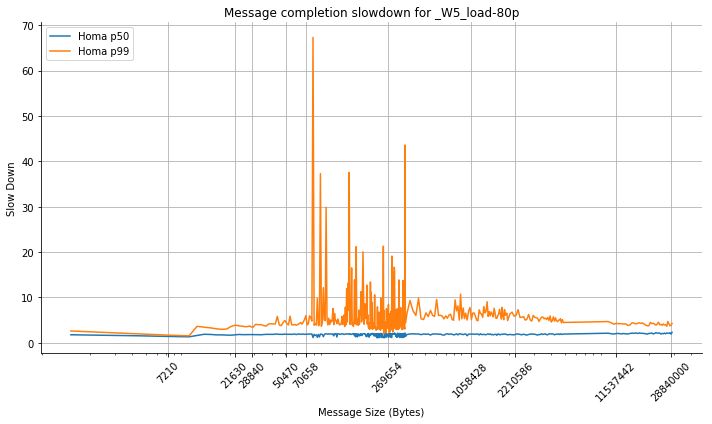

In [14]:
plt.figure(figsize=figsize)
plt.grid()

plt.plot(msgSizes,p50SlowDowns,label='Homa p50')
plt.plot(msgSizes,p99SlowDowns,label='Homa p99')

plt.ylabel('Slow Down')
plt.xlabel('Message Size (Bytes)')
plt.title('Message completion slowdown for '+simName)
plt.legend(loc='upper left')

# plt.ylim([1,15])
# plt.yscale('log')
# yticks = [1,2,3,4,15]
# plt.yticks(yticks, yticks)
plt.xscale('log')
if (networkLoad==0.5):
    xticks = [5768,18746,27398,47586,70658,191786,961814,1922186,4806186,28840000]
    plt.xticks(xticks, xticks, rotation=45)
elif (networkLoad==0.8):
    xticks = [7210,21630,28840,50470,70658,269654,1058428,2210586,11537442,28840000]
    plt.xticks(xticks, xticks, rotation=45)

plt.gca().spines["right"].set_visible(False)
plt.gca().spines["top"].set_visible(False)
plt.tight_layout()

# plt.savefig('MsgComletionSlowdown'+simName+'.png')
plt.show()

In [10]:
binnedMsgCompletionTimesDict = {}

bdpPkts = 7
bdpBytes = bdpPkts * pktPayloadSize
for msgSize, msgCompletionTimes in msgCompletionTimesDict.items():    
    binnedMsgSize = (int)(msgSize // bdpBytes + 1) * bdpBytes
    if (binnedMsgSize in binnedMsgCompletionTimesDict.keys()):
        binnedMsgCompletionTimesDict[binnedMsgSize] += msgCompletionTimes
    else:
        binnedMsgCompletionTimesDict[binnedMsgSize] = msgCompletionTimes

In [11]:
binnedMsgSizes = []
binnedP50CompletionTimes = []
binnedP99CompletionTimes = []
binnedBaseCompletionTimes = []
binnedP50SlowDowns = []
binnedP99SlowDowns = []

for msgSize, msgCompletionTimes in binnedMsgCompletionTimesDict.items():
    
    binnedMsgSizes.append(msgSize)
    
    times = np.array(msgCompletionTimes)
    p50CompletionTime = np.percentile(times,50)
    binnedP50CompletionTimes.append(p50CompletionTime)
    p99CompletionTime = np.percentile(times,99)
    binnedP99CompletionTimes.append(p99CompletionTime)
    
    baseCompletionTime = (msgSize+pktPayloadSize)*8.0/10e9 + 0.5e-6
    binnedBaseCompletionTimes.append(baseCompletionTime)
    
    binnedP50SlowDowns.append(p50CompletionTime / baseCompletionTime)
    binnedP99SlowDowns.append(p99CompletionTime / baseCompletionTime)
    
zipData = sorted(zip(binnedMsgSizes,
                     binnedP50CompletionTimes,
                     binnedP99CompletionTimes,
                     binnedBaseCompletionTimes,
                     binnedP50SlowDowns,
                     binnedP99SlowDowns))
    
binnedMsgSizes = np.array([x for x,_,_,_,_,_ in zipData])
binnedP50CompletionTimes = np.array([x for _,x,_,_,_,_ in zipData])
binnedP99CompletionTimes = np.array([x for _,_,x,_,_,_ in zipData])
binnedBaseCompletionTimes = np.array([x for _,_,_,x,_,_ in zipData])
binnedP50SlowDowns = np.array([x for _,_,_,_,x,_ in zipData])
binnedP99SlowDowns = np.array([x for _,_,_,_,_,x in zipData])

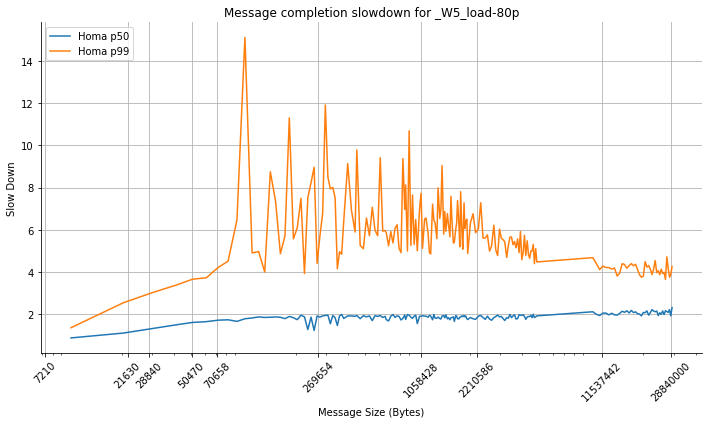

In [15]:
plt.figure(figsize=figsize)
plt.grid()

plt.plot(binnedMsgSizes,binnedP50SlowDowns,label='Homa p50')
plt.plot(binnedMsgSizes,binnedP99SlowDowns,label='Homa p99')

plt.ylabel('Slow Down')
plt.xlabel('Message Size (Bytes)')
plt.title('Message completion slowdown for '+simName)
plt.legend(loc='upper left')

# plt.ylim([1,15])
# plt.yscale('log')
# yticks = [1,2,3,4,15]
# plt.yticks(yticks, yticks)
plt.xscale('log')
if (networkLoad==0.5):
    xticks = [5768,18746,27398,47586,70658,191786,961814,1922186,4806186,28840000]
    plt.xticks(xticks, xticks, rotation=45)
elif (networkLoad==0.8):
    xticks = [7210,21630,28840,50470,70658,269654,1058428,2210586,11537442,28840000]
    plt.xticks(xticks, xticks, rotation=45)

plt.gca().spines["right"].set_visible(False)
plt.gca().spines["top"].set_visible(False)
plt.tight_layout()

plt.savefig('MsgComletionSlowdown'+simName+'.png')
plt.show()